In [3]:
import numpy as np

from qiskit import IBMQ, BasicAer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, execute
from qiskit.tools.jupyter import *


In [5]:
IBMQ.save_account('5f8fd0f78d9985efd899caa627e8316048089fa84d68335f95087da7b34a38b0fb1df500c218107b57387c184f63b6ad1a2b226bd209ee1bfc1375ed47058b93')

In [6]:
provider = IBMQ.load_account()

/usr/local/lib/python3.9/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


In [7]:
from qiskit.visualization import plot_histogram

In [8]:
def dj_oracle(case,n):
    # Necesitamos un objeto de tipo QuantumCircuit
    # con n+1 cubits, el argumento de entrada n + un cubit que seria el auxiliar o target
    oracle_qc = QuantumCircuit(n+1)

    # Empezamos por el caso en el que el oraculo se encuentra balanceado
    # es decir, la mitad de los casos obtendremos 0 y la otra mitad 1
    if case == "balanced":
        # aplicamos las compuertas CNOT para cada cubit, utilizando el ultimo cubit como target
        for qubit in range(n):
            oracle_qc.cx(qubit,n)
    
    # Ahora el caso en el que el oraculo es constante
    if case == "constant":
        # Primero se debe decidir cual sera el resultado del oraculo
        # (siempre 0 o siempre 1)
        output = np.random.randint(2)
        if output == 1:
            oracle_qc.x(n)
    
    oracle_gate = oracle_qc.to_gate()
    oracle_gate.name = "Oracle" # El nombre que se mostrara en el diagrama del circuito
    return oracle_gate

In [9]:
def dj_algorithm(n, case = 'random'):
    dj_circuit = QuantumCircuit(n+1, n) # n bits clasicos para asignar el resultado de la medicion

    for qubit in range(n):
        dj_circuit.h(qubit)

    dj_circuit.x(n)
    dj_circuit.h(n)

    # Ahora agregamos la compuerta oracle a nuestro circuito:
    if case == 'random':
        random = np.random.randint(2)
        if random == 0:
            case = 'constant'
        else:
            case = 'balanced'
    oracle = dj_oracle(case, n)
    dj_circuit.append(oracle, range(n+1))

    # finalmente, aplicamos las compuertas H de nuevo y ejecutamos una medicion
    for i in range(n):
        dj_circuit.h(i)
        dj_circuit.measure(i,i)
    return dj_circuit

In [10]:
n = 4
dj_circuit = dj_algorithm(n)
dj_circuit.draw()

┌───┐     ┌─────────┐┌───┐┌─┐         
q_0: ┤ H ├─────┤0        ├┤ H ├┤M├─────────
     ├───┤     │         │├───┤└╥┘┌─┐      
q_1: ┤ H ├─────┤1        ├┤ H ├─╫─┤M├──────
     ├───┤     │         │├───┤ ║ └╥┘┌─┐   
q_2: ┤ H ├─────┤2 Oracle ├┤ H ├─╫──╫─┤M├───
     ├───┤     │         │├───┤ ║  ║ └╥┘┌─┐
q_3: ┤ H ├─────┤3        ├┤ H ├─╫──╫──╫─┤M├
     ├───┤┌───┐│         │└───┘ ║  ║  ║ └╥┘
q_4: ┤ X ├┤ H ├┤4        ├──────╫──╫──╫──╫─
     └───┘└───┘└─────────┘      ║  ║  ║  ║ 
c: 4/═══════════════════════════╩══╩══╩══╩═
                                0  1  2  3

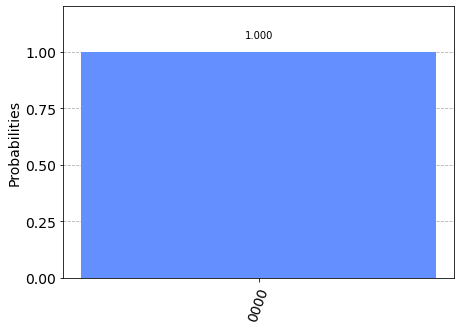

In [11]:
backend = BasicAer.get_backend('qasm_simulator')
shots = 1024
dj_circuit = dj_algorithm(n)
results = execute(dj_circuit, backend=backend, shots=shots).result()
answer = results.get_counts()

plot_histogram(answer)

#0000 -> Constant, 1111->Balanced

In [12]:
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= (n+1) and not x.configuration().simulator and x.status().operational==True ))
print("least busy backend: ", backend)
%qiskit_job_watcher
dj_circuit = dj_algorithm(n)
job = execute(dj_circuit, backend=backend, shots=shots, optimization_level=3) # Optimization level = highest, chooses best gate map, optimizes gates

least busy backend:  ibmq_quito


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

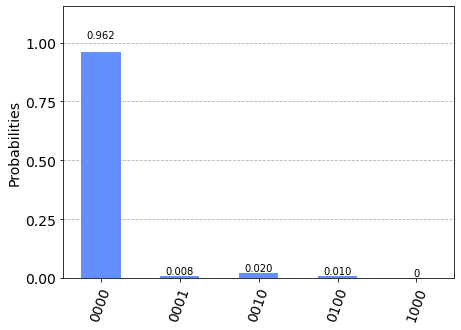

In [13]:
results = job.result()
answer = results.get_counts()
plot_histogram(answer)

In [ ]:
# Recuperar submisiones previas
backend = provider.get_backend('ibmq_quito')
old_job = backend.retrieve_job('610054ef5814b983a8534c8d')
results = old_job.result()
answer = results.get_counts()
plot_histogram(answer)

For the constant case, the operations that we applied are very simple, and mos toperations are single-qubit at most, so we get a high fidelity result. For the balanced case, we applied a lot of CNOT gates, which introduce a lot of noise, therefore reducing the fidelity of finding the target state.